## Import required libraries

In [1]:
# Import required libraries
import re
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, NMF
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import Ridge
from sklearn.metrics import (mean_squared_error, mean_absolute_error, 
                             silhouette_score, r2_score, mean_squared_log_error)
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from scipy.sparse import csr_matrix

## Load and explore data

In [2]:
def load_data(filenames):
    """
    Given a list of CSV files, read and return a list of dataframes.
    
    Args:
    filenames: list of filenames (str)

    Returns:
    list of dataframes
    """
    return [pd.read_csv(file, encoding='utf-8-sig') for file in filenames]

def display_dataframe_info(df_list, df_names):
    """
    Display basic information about a list of dataframes.

    Args:
    df_list: list of dataframes
    df_names: list of dataframe names (str)
    """
    for i, df in enumerate(df_list):
        print(f"Details for DataFrame - {df_names[i]}")
        print("------------------------------------")
        print(f"Shape: {df.shape}")
        print(f"Columns: {df.columns.tolist()}\n")
        print("Info:")
        print(df.info())
        print("\n")


# Filenames to load data from
filenames = ['initial_data/movies.csv', 'initial_data/ratings.csv']

# Load data into dataframes
movies_df, ratings_df = load_data(filenames)

# List of dataframes and their corresponding names
dataframes = [movies_df, ratings_df]
df_names = ["Movies DataFrame", "Ratings DataFrame"]

# Display info about the dataframes
display_dataframe_info(dataframes, df_names)

Details for DataFrame - Movies DataFrame
------------------------------------
Shape: (10329, 3)
Columns: ['movieId', 'title', 'genres']

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10329 entries, 0 to 10328
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  10329 non-null  int64 
 1   title    10329 non-null  object
 2   genres   10329 non-null  object
dtypes: int64(1), object(2)
memory usage: 242.2+ KB
None


Details for DataFrame - Ratings DataFrame
------------------------------------
Shape: (105339, 4)
Columns: ['userId', 'movieId', 'rating', 'timestamp']

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105339 entries, 0 to 105338
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     105339 non-null  int64  
 1   movieId    105339 non-null  int64  
 2   rating     105339 non-null  float64
 3   timestamp  105339 non-null

## Preprocess data

In [3]:
def preprocess_dataframe(df):
    """
    Preprocess a dataframe: extract the year from the title, clean the title, split and binarize the genres.

    Args:
    df: dataframe

    Returns:
    processed dataframe, binarized genres dataframe
    """
    # Extract year from the title
    df['year'] = df['title'].str.extract(r'\((\d{4})\)')
    df['year'] = df['year'].fillna('').astype(str)
    
    # Clean the title
    df['title'] = df['title'].str.replace(r'\(\d{4}\)', '').str.rstrip()
    
    # Split and binarize the genres
    df['genres_split'] = df['genres'].str.strip().str.split("|")
    df['genres'] = df['genres'].str.strip().replace("|", " ")
    
    mlb = MultiLabelBinarizer()
    genres_df = pd.DataFrame(mlb.fit_transform(df.pop('genres_split')), columns=mlb.classes_)
    df = df.join(genres_df)
    
    return df, genres_df

In [4]:
# Preprocess the dataframe
movies_df_processed, genres_df_processed = preprocess_dataframe(movies_df.copy())

print("Unique values in year:", len(movies_df_processed['year'].unique()))
print(movies_df_processed['year'].unique())

print("Unique values in genres:", len(genres_df_processed.columns))
print(genres_df_processed.columns)

Unique values in year: 101
['1995' '1994' '1996' '1976' '1992' '1967' '1993' '1964' '1977' '1965'
 '1982' '1985' '1990' '1991' '1989' '1937' '1940' '1969' '1981' '1973'
 '1970' '1960' '1955' '1959' '1968' '1988' '1975' '1948' '1950' '1997'
 '1958' '1972' '1943' '1952' '1951' '1957' '1961' '1954' '1934' '1944'
 '1963' '1942' '1941' '1953' '1939' '1946' '1945' '1938' '1947' '1935'
 '1936' '1956' '1926' '1949' '1932' '1974' '1971' '1979' '1987' '1986'
 '1980' '1978' '1966' '1962' '1983' '1984' '1933' '1931' '1922' '1998'
 '1927' '1930' '1928' '1929' '1999' '2000' '1925' '1923' '1921' '2001'
 '1924' '2002' '2003' '1920' '1919' '1915' '2004' '1916' '2005' '2006'
 '1902' '2007' '2008' '2009' '2010' '2011' '2012' '2013' '2014' '' '2015']
Unique values in genres: 20
Index(['(no genres listed)', 'Action', 'Adventure', 'Animation', 'Children',
       'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir',
       'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller',


C:\Users\flori\AppData\Local\Temp\ipykernel_13528\3990685612.py:16: FutureWarning: The default value of regex will change from True to False in a future version.
  df['title'] = df['title'].str.replace(r'\(\d{4}\)', '').str.rstrip()


## Exploratory Data Analysis (EDA)

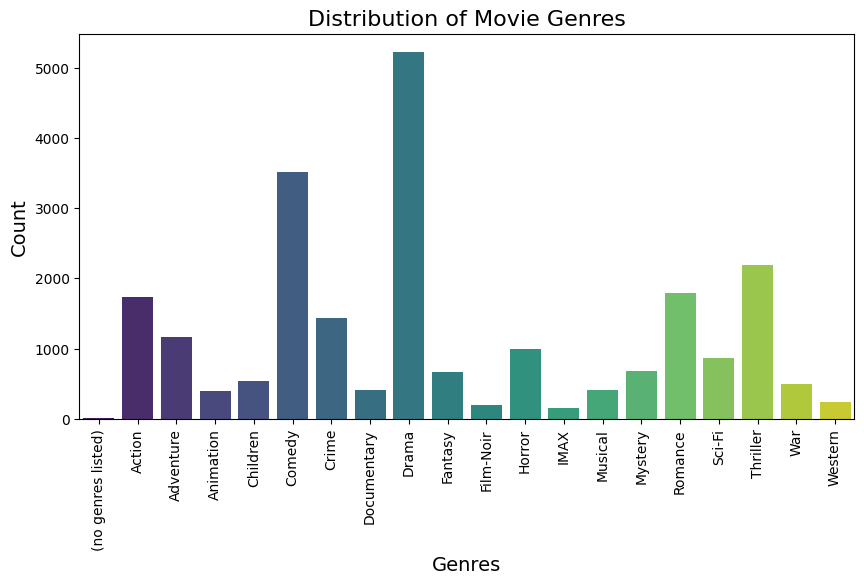

Number of movies where no genre is listed: 7
Number of movies where IMAX is listed as a genre: 152
Number of movies where only IMAX is listed as a genre: 0


In [5]:
def visualize_genre_distribution(df, genres_df):
    """
    Visualize genre distribution: compute the sum of each genre and plot it, 
    also print the number of movies where no genre is listed and where IMAX is listed as a genre.
    
    Args:
    df: dataframe
    genres_df: binarized genres dataframe
    """
    genre_counts = genres_df.sum()
    plt.figure(figsize=(10,5))
    sns.barplot(x=genre_counts.index, y=genre_counts.values, palette="viridis")
    plt.title('Distribution of Movie Genres', fontsize=16)
    plt.xlabel('Genres', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.xticks(rotation=90)
    plt.show()
    
    try:
        no_genre_count = len(df[df['(no genres listed)'] == 1])
        print(f"Number of movies where no genre is listed: {no_genre_count}")
    except KeyError:
        print("'(no genres listed)' category does not exist in the DataFrame.")
    try:
        imax_count = len(df[df['IMAX'] == 1])
        print(f"Number of movies where IMAX is listed as a genre: {imax_count}")
        non_imax_columns = ['movieId', 'title', 'year', 'genres', 'IMAX', '(no genres listed)']
        only_imax_count = len(df[(df['IMAX'] == 1) & (df.drop(columns=non_imax_columns).sum(axis=1) == 0)])
        print(f"Number of movies where only IMAX is listed as a genre: {only_imax_count}")
    except KeyError:
        print("'IMAX' category does not exist in the DataFrame.")

visualize_genre_distribution(movies_df_processed, genres_df_processed)

In the context of movie ratings, movies with very few ratings may not provide a reliable representation of audience preferences. They could potentially distort the analysis and the recommendations of a recommendation system. Similarly, users who have provided very few ratings might not give a clear picture of their movie preferences, leading to less reliable user-specific recommendations.

## Data Cleansing

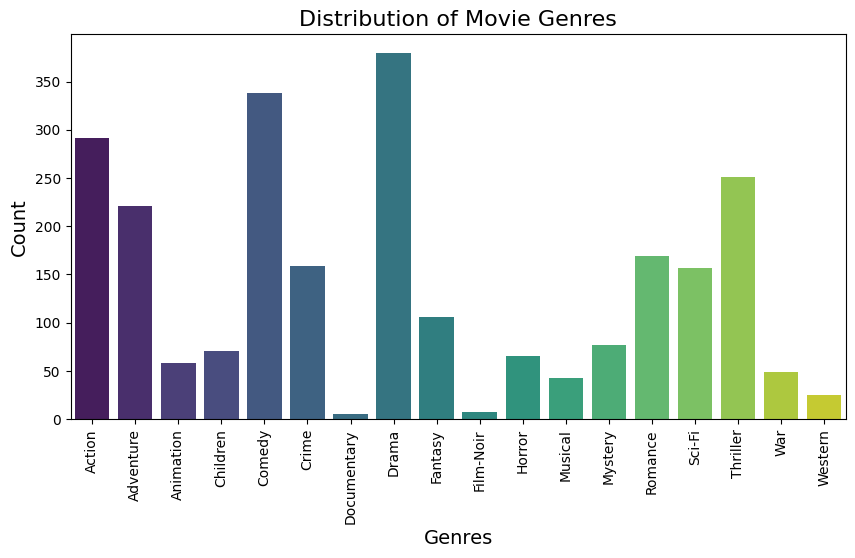

'(no genres listed)' category does not exist in the DataFrame.
'IMAX' category does not exist in the DataFrame.


In [6]:
MIN_RATINGS_PER_MOVIE = 30
MIN_RATINGS_PER_USER = 30

def cleanse_dataframes(movies_df, ratings_df, min_ratings_per_movie=MIN_RATINGS_PER_MOVIE, min_ratings_per_user=MIN_RATINGS_PER_USER):
    """
    Cleanse dataframes: exclude entries where no genres are listed and remove the 'IMAX' genre, 
    filter out movies and users with fewer than a certain number of ratings.

    Args:
    movies_df: dataframe
    ratings_df: dataframe
    min_ratings_per_movie: minimum number of ratings per movie (int)
    min_ratings_per_user: minimum number of ratings per user (int)

    Returns:
    cleaned movies dataframe, cleaned ratings dataframe
    """
    # Remove entries where no genres are listed
    movies_df = movies_df[movies_df['(no genres listed)'] == 0].drop(columns=['(no genres listed)'])
    
    # Remove the 'IMAX' genre
    movies_df['genres'] = movies_df['genres'].str.replace(r'(IMAX[|])|([|]IMAX)', '', regex=True)
    movies_df = movies_df.drop(columns=['IMAX'])
    
    # Exclude movies where no genres are listed
    genre_columns = movies_df.columns[4:]
    movies_df = movies_df[movies_df[genre_columns].sum(axis=1) != 0]
    
    # Exclude movies not in the ratings dataframe
    rated_movie_ids = ratings_df['movieId'].unique()
    missing_movie_ids = [movieId for movieId in rated_movie_ids if movieId not in movies_df['movieId'].values]
    if missing_movie_ids:
        ratings_df = ratings_df[~ratings_df['movieId'].isin(missing_movie_ids)]
    
    # Filter out movies and users with fewer than a certain number of ratings
    ratings_df = ratings_df.groupby('movieId').filter(lambda x: len(x) >= min_ratings_per_movie)

    # Filter out users with insufficient ratings
    ratings_df = ratings_df.groupby('userId').filter(lambda x: len(x) >= min_ratings_per_user)

    # Update movies_df to only include movies that are still in ratings_df
    rated_movie_ids = ratings_df['movieId'].unique()
    movies_df = movies_df[movies_df['movieId'].isin(rated_movie_ids)]

    # Reset dataframe indices
    movies_df.reset_index(drop=True, inplace=True)
    ratings_df.reset_index(drop=True, inplace=True)
    
    return movies_df, ratings_df

# Clean data
movies_df_clean, ratings_df_clean = cleanse_dataframes(movies_df_processed, ratings_df)

# Function to get genre DataFrame from cleaned DataFrame
def extract_genre_dataframe(df):
    """Extracts the dataframe containing only genre columns."""
    genre_columns = df.columns[4:]
    return df[genre_columns]

# Get genre DataFrame from cleaned DataFrame
genres_df_clean = extract_genre_dataframe(movies_df_clean)

# Revisit EDA with cleaned data
visualize_genre_distribution(movies_df_clean, genres_df_clean)

- The year of the movie was extracted from the title and added as a separate column.
- The title was cleaned by removing the year.
- The genres were split, cleaned and then binarized.
- Movies and users with fewer than a certain number of ratings were removed.

In [7]:
ratings_df_clean.to_csv('processed_data/ratings_df_clean.csv', index=False, encoding='utf-8-sig')

movies_df_clean.to_csv('processed_data/movies_df_clean.csv', index=False, encoding='utf-8-sig')

In [8]:
movies_df_clean

,movieId,title,genres,year,Action,Adventure,Animation,Children,Comedy,Crime,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,0,1,1,1,1,0,...,1,0,0,0,0,0,0,0,0,0
1,2,Jumanji,Adventure|Children|Fantasy,1995,0,1,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men,Comedy|Romance,1995,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,5,Father of the Bride Part II,Comedy,1995,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,6,Heat,Action|Crime|Thriller,1995,1,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
883,91529,"Dark Knight Rises, The",Action|Adventure|Crime,2012,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
884,99114,Django Unchained,Action|Drama|Western,2012,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
885,109374,"Grand Budapest Hotel, The",Comedy|Drama,2014,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
886,109487,Interstellar,Sci-Fi,2014,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [9]:
ratings_df_clean

,userId,movieId,rating,timestamp
0,1,16,4.0,1217897793
1,1,24,1.5,1217895807
2,1,32,4.0,1217896246
3,1,47,4.0,1217896556
4,1,50,4.0,1217896523
...,...,...,...,...
56281,668,91529,4.0,1344747165
56282,668,99114,3.5,1367129093
56283,668,109374,4.0,1415763807
56284,668,109487,4.0,1415421771


In [10]:
def merge_dataframes(movies_df, ratings_df):
    """
    Merges the movies and ratings dataframes, drops the 'timestamp' column, 
    and rearranges the column order to present 'userId', 'rating', 'movieId', 'title' first.

    Args:
    movies_df: The dataframe containing movie details.
    ratings_df: The dataframe containing movie ratings.

    Returns:
    merged_df: The merged and rearranged dataframe.
    """
    # Merge movies and ratings DataFrames based on 'movieId'
    merged_df = pd.merge(ratings_df, movies_df, on='movieId')

    # Define the new column order with 'userId', 'rating', 'movieId', 'title' at the beginning
    new_col_order = ['userId', 'rating', 'movieId', 'title'] + [col for col in merged_df if col not in ['userId', 'rating', 'movieId', 'title']]

    # Reorder the columns
    merged_df = merged_df[new_col_order]

    return merged_df

# Merge and rearrange the pruned DataFrames
merged_df = merge_dataframes(movies_df_clean, ratings_df_clean)

# Display information about the final DataFrame
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56286 entries, 0 to 56285
Data columns (total 25 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   userId       56286 non-null  int64  
 1   rating       56286 non-null  float64
 2   movieId      56286 non-null  int64  
 3   title        56286 non-null  object 
 4   timestamp    56286 non-null  int64  
 5   genres       56286 non-null  object 
 6   year         56286 non-null  object 
 7   Action       56286 non-null  int32  
 8   Adventure    56286 non-null  int32  
 9   Animation    56286 non-null  int32  
 10  Children     56286 non-null  int32  
 11  Comedy       56286 non-null  int32  
 12  Crime        56286 non-null  int32  
 13  Documentary  56286 non-null  int32  
 14  Drama        56286 non-null  int32  
 15  Fantasy      56286 non-null  int32  
 16  Film-Noir    56286 non-null  int32  
 17  Horror       56286 non-null  int32  
 18  Musical      56286 non-null  int32  
 19  Myst

In [11]:
merged_df.to_csv('processed_data/merged_df.csv', index=False, encoding='utf-8-sig')

In [12]:
# Display the first few rows of the merged DataFrame
merged_df

,userId,rating,movieId,title,timestamp,genres,year,Action,Adventure,Animation,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,4.0,16,Casino,1217897793,Crime|Drama,1995,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,4.0,16,Casino,842686699,Crime|Drama,1995,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,24,4.0,16,Casino,963468757,Crime|Drama,1995,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,29,3.0,16,Casino,836820223,Crime|Drama,1995,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,31,4.0,16,Casino,832397760,Crime|Drama,1995,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56281,615,4.0,2872,Excalibur,955128875,Adventure|Fantasy,1981,0,1,0,...,1,0,0,0,0,0,0,0,0,0
56282,627,3.5,2872,Excalibur,1237932607,Adventure|Fantasy,1981,0,1,0,...,1,0,0,0,0,0,0,0,0,0
56283,636,2.0,2872,Excalibur,939631128,Adventure|Fantasy,1981,0,1,0,...,1,0,0,0,0,0,0,0,0,0
56284,637,5.0,2872,Excalibur,983919230,Adventure|Fantasy,1981,0,1,0,...,1,0,0,0,0,0,0,0,0,0


## More EDA

Number of unique users: 476
Number of unique movies: 888



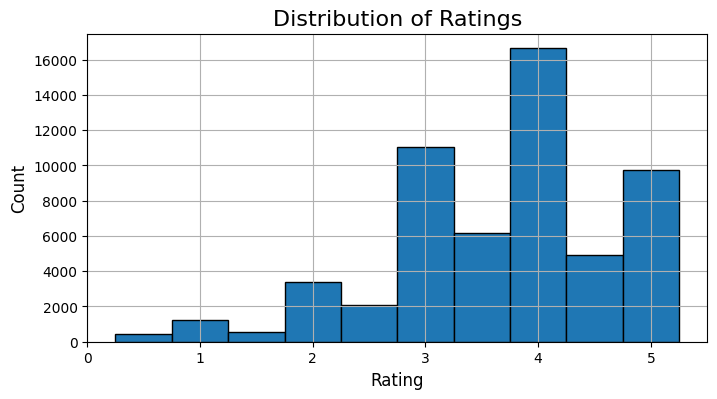


Ratings per User:
  Average: 118.25
  Minimum: 30
  Maximum: 794

Ratings per Movie:
  Average: 63.39
  Minimum: 26
  Maximum: 286

Average User Rating:
  Overall Average: 3.74

Average Movie Rating:
  Overall Average: 3.59



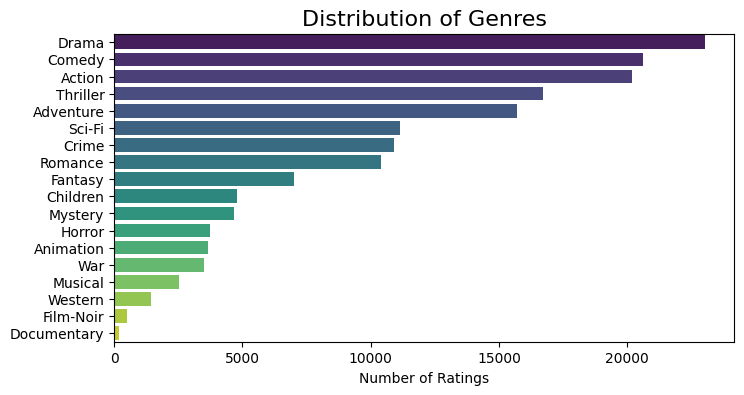


Top 20 Movies with Highest Average Rating (with more than 10 ratings):

                                              rating          
                                               count      mean
title                                                         
Shawshank Redemption, The                        260  4.457692
Cinema Paradiso (Nuovo cinema Paradiso)           33  4.439394
Ran                                               30  4.416667
Princess Mononoke (Mononoke-hime)                 50  4.390000
Citizen Kane                                      71  4.359155
On the Waterfront                                 34  4.352941
Godfather, The                                   185  4.351351
Rear Window                                       71  4.330986
Usual Suspects, The                              209  4.327751
Chinatown                                         68  4.323529
Schindler's List                                 226  4.300885
Third Man, The                               

In [13]:
def explore_merged_data(df):
    """
    Explore merged data and perform various analyses.

    Args:
    df: Merged dataframe

    Returns:
    None
    """
    # Check number of unique users and movies
    n_users = df['userId'].nunique()
    n_movies = df['movieId'].nunique()
    print(f"Number of unique users: {n_users}")
    print(f"Number of unique movies: {n_movies}\n")

    # Visualize distribution of ratings
    plt.figure(figsize=(8, 4))
    plt.title('Distribution of Ratings', fontsize=16)
    df['rating'].hist(bins=10, range=(0.25, 5.25), edgecolor='black')
    plt.xlabel('Rating', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.show()

    # Ratings per user
    ratings_per_user = df.groupby('userId')['rating'].count()
    print("\nRatings per User:")
    print(f"  Average: {ratings_per_user.mean():.2f}")
    print(f"  Minimum: {ratings_per_user.min()}")
    print(f"  Maximum: {ratings_per_user.max()}\n")

    # Ratings per movie
    ratings_per_movie = df.groupby('movieId')['rating'].count()
    print("Ratings per Movie:")
    print(f"  Average: {ratings_per_movie.mean():.2f}")
    print(f"  Minimum: {ratings_per_movie.min()}")
    print(f"  Maximum: {ratings_per_movie.max()}\n")

    # Average rating per user
    avg_rating_per_user = df.groupby('userId')['rating'].mean()
    print("Average User Rating:")
    print(f"  Overall Average: {avg_rating_per_user.mean():.2f}\n")

    # Average rating per movie
    avg_rating_per_movie = df.groupby('movieId')['rating'].mean()
    print("Average Movie Rating:")
    print(f"  Overall Average: {avg_rating_per_movie.mean():.2f}\n")

    # Visualize distribution of genres
    genre_columns = df.columns[7:]
    genre_count = df[genre_columns].astype(int).sum().sort_values(ascending=False)
    plt.figure(figsize=(8, 4))
    plt.title('Distribution of Genres', fontsize=16)
    sns.barplot(x=genre_count.values, y=genre_count.index, palette='viridis')
    plt.xlabel('Number of Ratings')
    plt.show()

    # Top 20 movies with highest average rating (with more than 10 ratings)
    movie_stats = df.groupby('title')[['rating']].agg(['count', 'mean'])
    top_rated_movies = movie_stats.loc[movie_stats[('rating', 'count')] > 10].sort_values(('rating', 'mean'), ascending=False).head(20)
    print("\nTop 20 Movies with Highest Average Rating (with more than 10 ratings):\n")
    print(top_rated_movies)


explore_merged_data(merged_df)

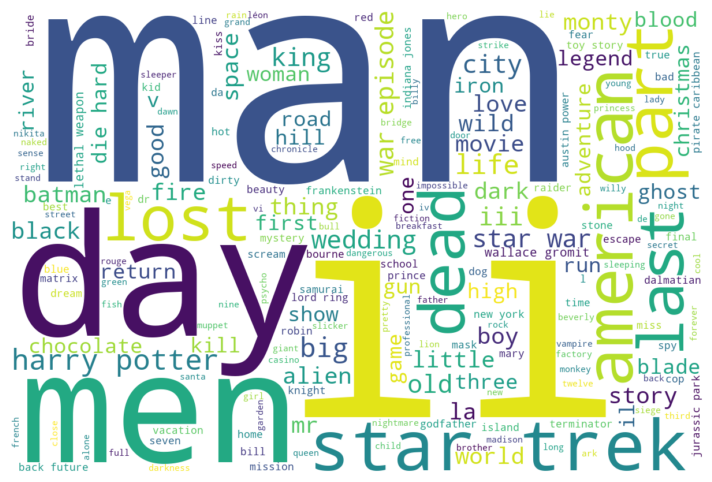

In [14]:
tweet_tokenizer = TweetTokenizer()
lemmatizer = WordNetLemmatizer()

def process_text(text):
    """
    Tokenize, remove stopwords, and lemmatize the text.

    Args:
    text: Input text

    Returns:
    Processed text
    """
    words = tweet_tokenizer.tokenize(text)
    words = [lemmatizer.lemmatize(word.lower().replace("'", '')) for word in words if word.isalpha() and word.lower() not in stopwords.words('english')]
    return ' '.join(words)

def generate_wordcloud(df):
    """
    Generate and display a wordcloud from the movie titles in the dataframe.

    Args:
    df: Dataframe containing movie titles

    Returns:
    None
    """
    wordcloud = WordCloud(width=1200, height=800, background_color="white").generate(process_text(' '.join(df['title'])))
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

# Generate wordcloud
generate_wordcloud(movies_df_clean)

## Apply the cosine similarity measurement to calculate the movie similarity using the extracted Bag of Words (BoW) feature vectors

In [15]:
def create_similarity_matrix(df, vectorizer):
    """
    Create a similarity matrix using a specified vectorizer.

    Args:
    df: Dataframe containing movie data
    vectorizer: CountVectorizer to apply to the movie data

    Returns:
    Similarity matrix
    """
    processed_titles_genres = df[['title', 'genres']].agg(' '.join, axis=1).apply(process_text)
    feature_matrix = vectorizer.fit_transform(processed_titles_genres)
    similarity_matrix = cosine_similarity(feature_matrix, feature_matrix)

    return similarity_matrix

# Process titles and genres and create the Bag-of-Words (BoW) similarity matrix
movies_df_clean['processed_title_genres'] = movies_df_clean[['title', 'genres']].agg(' '.join, axis=1).apply(process_text)
bow_vectorizer = CountVectorizer()
bow_similarity_matrix = create_similarity_matrix(movies_df_clean, bow_vectorizer)

# Save cosine similarity based on BoW
df_bow = pd.DataFrame(bow_similarity_matrix)
df_bow.to_csv('processed_data/bow_similarity.csv', index=False)

In [68]:
df_bow

,0,1,2,3,4,5,6,7,8,9,...,878,879,880,881,882,883,884,885,886,887
0,1.000000,0.566947,0.169031,0.169031,0.000000,0.218218,0.188982,0.169031,0.000000,0.000000,...,1.000000,0.000000,0.267261,0.000000,0.218218,0.154303,0.000000,0.169031,0.0,0.188982
1,0.566947,1.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,...,0.566947,0.000000,0.353553,0.000000,0.288675,0.204124,0.000000,0.000000,0.0,0.250000
2,0.169031,0.000000,1.000000,0.200000,0.000000,0.516398,0.000000,0.400000,0.000000,0.223607,...,0.169031,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.0,0.000000
3,0.169031,0.000000,0.200000,1.000000,0.000000,0.258199,0.000000,0.200000,0.000000,0.000000,...,0.169031,0.000000,0.158114,0.000000,0.000000,0.000000,0.000000,0.200000,0.0,0.000000
4,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.500000,0.000000,0.288675,0.000000,...,0.000000,0.612372,0.176777,0.000000,0.288675,0.408248,0.223607,0.000000,0.0,0.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
883,0.154303,0.204124,0.000000,0.000000,0.408248,0.000000,0.408248,0.000000,0.235702,0.000000,...,0.154303,0.333333,0.288675,0.000000,0.471405,1.000000,0.182574,0.000000,0.0,0.408248
884,0.000000,0.000000,0.000000,0.000000,0.223607,0.000000,0.223607,0.200000,0.258199,0.223607,...,0.000000,0.365148,0.158114,0.316228,0.258199,0.182574,1.000000,0.200000,0.0,0.223607
885,0.169031,0.000000,0.200000,0.200000,0.000000,0.258199,0.000000,0.400000,0.258199,0.223607,...,0.169031,0.182574,0.000000,0.316228,0.000000,0.000000,0.200000,1.000000,0.0,0.000000
886,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000


In [16]:
def get_user_recommendations_similarity(user_id, ratings_df, movies_df, similarity_matrix, similarity_threshold=0.6, top_n=10):
    """
    Get the top 10 recommended movies for a given user.

    Args:
    user_id: ID of the user
    ratings_df: Dataframe containing user movie ratings
    movies_df: Dataframe containing movie data
    similarity_matrix: Similarity matrix
    similarity_threshold: Similarity threshold for considering movies as similar (default: 0.6)

    Returns:
    Dataframe containing the top 10 recommended movies
    """
    # Check if the user exists in the ratings DataFrame
    if user_id not in ratings_df['userId'].unique():
        print(f"User {user_id} not found in ratings data.")

        # Check if there are any users in the ratings DataFrame
        if ratings_df['userId'].nunique() == 0:
            print("No users found in ratings data.")
            return pd.DataFrame(columns=['title', 'similarity_score'])

        print("Selecting a random user for recommendations.")

        # Get a random user ID from the available user IDs in the ratings DataFrame
        user_id = random.choice(ratings_df['userId'].unique().tolist())
        print("Selected user", user_id)

    # Get the user's ratings
    user_ratings = ratings_df[ratings_df['userId'] == user_id]

    # Check if the user has rated any movies
    if user_ratings.empty:
        return pd.DataFrame(columns=['title', 'similarity_score'])

    # Merge with movies DataFrame to get movie titles
    user_ratings = user_ratings.merge(movies_df[['movieId', 'title']], how='left', on='movieId')

    # Get the top 10 rated movies by this user
    top_rated_by_user = user_ratings.sort_values('rating', ascending=False).head(top_n)

    recommended_movies = []

    # For each of the top rated movies, find the most similar movies
    for _, row in top_rated_by_user.iterrows():
        movie_title = row['title']
        idx = movies_df[movies_df['title'] == movie_title].index[0]
        similarity_scores = list(enumerate(similarity_matrix[idx]))
        similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)

        # Get the top similar movies
        for i, score in similarity_scores:
            similar_movie_id = movies_df['movieId'].iloc[i]
            similar_movie_title = movies_df['title'].iloc[i]

            # Check if the user has already seen this movie and if it meets the similarity threshold
            # and if the movie is not already in the recommended_movies list
            if not ((user_ratings['title'] == similar_movie_title).any() or similar_movie_title in [rec[1] for rec in recommended_movies]) and score >= similarity_threshold:
                recommended_movies.append((similar_movie_id, similar_movie_title, score))

    # Sort the recommended movies by similarity score
    recommended_movies = sorted(recommended_movies, key=lambda x: x[2], reverse=True)

    # If not enough recommendations, try again with lower similarity threshold
    if len(recommended_movies) < 10:
        return get_user_recommendations_similarity(user_id, ratings_df, movies_df, similarity_matrix, similarity_threshold - 0.1, top_n=10)

    # Return the top 10 recommended movies
    return pd.DataFrame(recommended_movies[:10], columns=['movieId', 'title', 'similarity_score'])

user_id = 7
get_user_recommendations_similarity(user_id, ratings_df_clean, movies_df_clean, bow_similarity_matrix, top_n=10)

,movieId,title,similarity_score
0,1717,Scream 2,1.000000
1,3273,Scream 3,1.000000
2,53972,Live Free or Die Hard,0.790569
3,1573,Face/Off,0.730297
4,2985,RoboCop,0.730297
5,8798,Collateral,0.730297
6,59369,Taken,0.730297
7,799,"Frighteners, The",0.670820
8,2232,Cube,0.670820
9,5679,"Ring, The",0.670820


## Generate a user profile based on movie genres and ratings

In [17]:
def generate_user_profiles(df):
    """
    Generate user profiles based on movie genres and user ratings using Ridge regression.

    Args:
        df (pandas.DataFrame): DataFrame with user ratings and movie genres.

    Returns:
        pandas.DataFrame: DataFrame with user profiles.
    """
    global user_profiles
    user_profiles = {}

    for user_id in df['userId'].unique():
        user_movies = df[df['userId'] == user_id]
        genre_ratings = user_movies.loc[:, 'Action':'Western'].values
        target_ratings = user_movies['rating'].values.reshape(-1, 1)

        model = Ridge(alpha=0.1, random_state=42)
        model.fit(genre_ratings, target_ratings)
        genre_weights = model.coef_.flatten()
        user_profiles[user_id] = genre_weights

    user_profiles_df = pd.DataFrame(user_profiles, index=df.loc[:, 'Action':'Western'].columns).T

    return user_profiles_df

def get_user_recommendations_user_profiles(user_id, user_profiles, df, top_n=10):
    """
    Recommend top N movies to a user based on their profile.

    Args:
        user_id (int): User ID for recommendation.
        user_profiles (pandas.DataFrame): DataFrame with user profiles.
        df (pandas.DataFrame): DataFrame with movie information.
        top_n (int): Number of top recommendations to return.

    Returns:
        pandas.DataFrame: DataFrame with recommended movies.
    """
    # If the user ID is not found, select a random user ID
    if user_id not in user_profiles.index:
        print(f"User ID {user_id} not found, selecting a random user.")
        user_id = df['userId'].sample(1).values[0]
        print(f"Selected user ID {user_id}")

    user_profile = user_profiles.loc[user_id]

    # Get the list of movies the user has already seen
    seen_movies = df[df['userId'] == user_id]['movieId'].values

    # Filter out the seen movies from the list of all movies
    unseen_movies = df[~df['movieId'].isin(seen_movies)]

    # Remove duplicates based on the 'title' column
    unseen_movies = unseen_movies.drop_duplicates(subset=['title'])

    # Apply a dot product between the user profile and the genre matrix to score movies
    movie_scores = unseen_movies.loc[:, 'Action':'Western'].dot(user_profile)

    # Get the movies with the highest scores
    top_movie_ids = movie_scores.nlargest(top_n).index
    recommended_movies = unseen_movies.loc[top_movie_ids, ['title']]

    # Include the computed scores in the recommended movies DataFrame
    recommended_movies['score'] = movie_scores.loc[top_movie_ids]
    recommended_movies = recommended_movies.reset_index().rename(columns={'index': 'movieId'})
    
    print(f"Showing top {top_n} recommendations for user {user_id}")

    return recommended_movies

In [65]:
user_profiles_df

,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
1,0.089709,0.497458,2.424100,-2.231264,-0.205292,0.938900,0.000000,0.167156,0.595366,-0.363666,0.272024,0.919643,0.264000,-0.105441,-0.101707,0.030119,0.807477,-0.244173
9,-0.131380,0.158019,0.000000,-1.060362,-0.035692,0.374811,0.110404,-0.069611,-0.074035,0.000000,-0.099001,0.000000,-0.439780,-0.255611,0.016058,0.145593,0.260751,-0.112266
24,-0.321816,-0.170035,0.000000,0.000000,-0.400331,0.222293,0.000000,-0.076168,-0.200471,0.628380,-0.045714,0.000000,0.354545,0.652486,0.077016,-0.356200,0.184404,-0.139173
29,-0.107269,0.243276,-0.038552,-0.056469,-0.166249,-0.100994,0.000000,-0.135662,0.041697,0.000000,0.236574,0.162025,0.128853,-0.120172,0.378081,0.186221,0.136081,-0.274823
31,-0.118014,0.250115,0.364919,-0.187129,-0.526187,0.390975,0.000000,-0.077281,-0.190221,0.000000,-0.016853,-0.695716,0.000000,0.206837,-0.640114,-0.643181,0.417900,-0.668488
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,-0.579917,-0.076128,0.111505,0.012157,-1.359147,-0.752690,0.000000,0.360749,-1.314333,0.903752,0.000000,0.761544,0.049367,0.654132,0.370827,-1.031390,-0.323944,0.000000
121,0.522232,-0.071685,0.001071,0.000000,0.066007,-0.077046,0.000000,1.114058,0.023553,0.978167,0.000000,0.001071,-0.350667,0.566155,0.324354,0.371852,0.547416,0.000000
120,-0.607975,-0.318303,-0.568276,0.319316,0.347936,0.252584,0.000000,0.500513,0.257195,0.000000,0.000000,0.579379,0.000000,0.186584,0.862951,0.000000,-0.147261,0.000000
182,-0.918075,0.177193,0.169121,0.169121,-0.471376,0.875424,0.000000,0.359935,-0.336640,1.871911,-0.062425,0.169121,-1.514265,-1.848554,0.135520,-0.407003,-0.143369,1.748414


In [18]:
# Generate user profiles
user_profiles_df = generate_user_profiles(merged_df)

# Save user profiles to a CSV file
user_profiles_df.to_csv('processed_data/user_profiles.csv')

# Example usage
user_id = 7
recommended_movies = get_user_recommendations_user_profiles(user_id, user_profiles_df, merged_df, top_n=10)
recommended_movies

Showing top 10 recommendations for user 7


,movieId,title,score
0,33392,"Sound of Music, The",1.971751
1,16263,Singin' in the Rain,1.836552
2,40356,Grease,1.836552
3,6920,"Blues Brothers, The",1.390479
4,46210,"Little Mermaid, The",1.343150
5,48754,Dirty Dancing,1.334787
6,49234,West Side Story,1.334787
7,50290,Moulin Rouge,1.334787
8,55024,Walk the Line,1.334787
9,38742,School of Rock,1.289835


## Clustering-based recommender system algorithm using K-means

In [19]:
user_profile_df = pd.read_csv('processed_data/user_profiles.csv')
user_profile_df.rename(columns={'Unnamed: 0': 'userId'}, inplace=True)
user_profile_df.head()

,userId,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,0.089709,0.497458,2.424100,-2.231264,-0.205292,0.938900,0.000000,0.167156,0.595366,-0.363666,0.272024,0.919643,0.264000,-0.105441,-0.101707,0.030119,0.807477,-0.244173
1,9,-0.131380,0.158019,0.000000,-1.060362,-0.035692,0.374811,0.110404,-0.069611,-0.074035,0.000000,-0.099001,0.000000,-0.439780,-0.255611,0.016058,0.145593,0.260751,-0.112266
2,24,-0.321816,-0.170035,0.000000,0.000000,-0.400331,0.222293,0.000000,-0.076168,-0.200471,0.628380,-0.045714,0.000000,0.354545,0.652486,0.077016,-0.356200,0.184404,-0.139173
3,29,-0.107269,0.243276,-0.038552,-0.056469,-0.166249,-0.100994,0.000000,-0.135662,0.041697,0.000000,0.236574,0.162025,0.128853,-0.120172,0.378081,0.186221,0.136081,-0.274823
4,31,-0.118014,0.250115,0.364919,-0.187129,-0.526187,0.390975,0.000000,-0.077281,-0.190221,0.000000,-0.016853,-0.695716,0.000000,0.206837,-0.640114,-0.643181,0.417900,-0.668488


In [20]:
user_profile_df.shape

(476, 19)

In [21]:
feature_names = list(user_profile_df.columns[1:])
print(feature_names)

['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']


In [22]:
user_profile_df.describe()

,userId,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
count,476.000000,476.000000,476.000000,476.000000,476.000000,476.000000,476.000000,476.000000,476.000000,476.000000,476.000000,476.000000,476.000000,476.000000,476.000000,476.000000,476.000000,476.000000,476.000000
mean,335.771008,-0.143005,0.009138,0.076654,-0.144154,-0.126223,0.147931,0.035434,0.114219,-0.030783,0.084562,-0.081533,-0.051209,0.062854,0.007469,-0.009101,-0.092846,0.157970,-0.105444
std,193.004511,0.377699,0.390778,0.677954,0.708761,0.382710,0.379046,0.404995,0.351929,0.491983,0.488189,0.540957,0.650642,0.536329,0.424092,0.459414,0.384650,0.529232,0.654461
min,1.000000,-1.752880,-1.693949,-2.982731,-2.728352,-1.928404,-1.662047,-3.066124,-1.322730,-2.729946,-3.006271,-3.010196,-3.816969,-2.683161,-2.231565,-2.141696,-1.931317,-3.014061,-3.452803
25%,166.750000,-0.330662,-0.175330,-0.215202,-0.487205,-0.331228,-0.059750,0.000000,-0.065357,-0.269857,0.000000,-0.308212,-0.303093,-0.160054,-0.216227,-0.254979,-0.278013,-0.104595,-0.356631
50%,336.500000,-0.151613,0.021865,0.053192,-0.109694,-0.135930,0.157442,0.000000,0.099241,-0.007379,0.000000,-0.000915,0.000000,0.074483,-0.006766,-0.003982,-0.073679,0.157566,0.000000
75%,506.750000,0.071763,0.202482,0.457763,0.190811,0.063732,0.358231,0.000000,0.291032,0.244492,0.197292,0.190245,0.209096,0.345148,0.237053,0.220027,0.096502,0.414735,0.177097
max,668.000000,1.075542,1.589832,3.221761,4.603075,2.019962,1.355168,2.804571,1.504312,2.099152,2.698642,2.075969,2.932823,1.818346,1.569056,2.346002,1.069604,2.693834,2.937761


In [23]:
# Use StandardScaler to make each feature with mean 0, standard deviation 1
scaler = StandardScaler()
user_profile_df[feature_names] = scaler.fit_transform(user_profile_df[feature_names])
print("mean: \n{} \n\n standard deviation: \n{}\n".format(user_profile_df[feature_names].mean(), user_profile_df[feature_names].std()))

mean: 
Action        -4.478211e-17
Adventure      6.530724e-18
Animation      3.731842e-18
Children       5.224579e-17
Comedy         7.463684e-17
Crime         -2.985474e-17
Documentary   -1.119553e-17
Drama         -3.731842e-17
Fantasy       -2.239105e-17
Film-Noir      3.731842e-18
Horror        -1.492737e-17
Musical       -7.463684e-18
Mystery        0.000000e+00
Romance        0.000000e+00
Sci-Fi        -5.597763e-18
Thriller      -1.865921e-17
War           -1.865921e-18
Western        2.239105e-17
dtype: float64 

 standard deviation: 
Action         1.001052
Adventure      1.001052
Animation      1.001052
Children       1.001052
Comedy         1.001052
Crime          1.001052
Documentary    1.001052
Drama          1.001052
Fantasy        1.001052
Film-Noir      1.001052
Horror         1.001052
Musical        1.001052
Mystery        1.001052
Romance        1.001052
Sci-Fi         1.001052
Thriller       1.001052
War            1.001052
Western        1.001052
dtype: float64



In [24]:
features = user_profile_df.loc[:, user_profile_df.columns != 'userId']
features.head()

,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0.616785,1.250922,3.466187,-2.947828,-0.206819,2.088931,-0.087584,0.150579,1.274042,-0.919110,0.654264,1.493714,0.375436,-0.266521,-0.201785,0.320016,1.228555,-0.212197
1,0.030811,0.381386,-0.113186,-1.294049,0.236803,0.599186,0.185310,-0.522900,-0.088006,-0.173397,-0.032326,0.078789,-0.938161,-0.620989,0.054822,0.620536,0.194413,-0.010436
2,-0.473920,-0.458985,-0.113186,0.203602,-0.716982,0.196390,-0.087584,-0.541550,-0.345269,1.115123,0.066283,0.078789,0.544437,1.522537,0.187648,-0.685378,0.050001,-0.051591
3,0.094715,0.599789,-0.170112,0.123846,-0.104695,-0.657404,-0.087584,-0.710780,0.147477,-0.173397,0.588662,0.328074,0.123186,-0.301293,0.843662,0.726272,-0.041404,-0.259080
4,0.066236,0.617307,0.425645,-0.060698,-1.046183,0.641874,-0.087584,-0.544716,-0.324413,-0.173397,0.119691,-0.991612,-0.117316,0.470601,-1.374961,-1.432247,0.491663,-0.861223


In [25]:
user_ids = user_profile_df.loc[:, user_profile_df.columns == 'userId']
user_ids.head()

,userId
0,1
1,9
2,24
3,29
4,31


#### Find best K with Silhouette score

In [26]:
def find_optimal_k(features, min_k=4, max_k=30):
    """
    Perform grid search to find the optimal number of clusters using silhouette score.

    Args:
        features (DataFrame): The feature vectors.
        min_k (int): The minimum value of k for grid search. Default is 4.
        max_k (int): The maximum value of k for grid search. Default is 30.

    Returns:
        int: The best value of k.
        float: The corresponding silhouette score.
    """
    # Create a list of candidate values for the number of clusters
    list_k = list(range(min_k, max_k + 1))

    # Create an empty list to store the silhouette scores for each fitted model
    silhouette_scores = []

    # Perform grid search and calculate silhouette scores
    for k in list_k:
        # Initialize and fit the KMeans model
        kmeans = KMeans(init='k-means++', n_clusters=k, random_state=42, n_init=25)
        kmeans.fit(features)

        # Calculate the silhouette score
        score = silhouette_score(features, kmeans.labels_)
        silhouette_scores.append(score)

    # Find the best value of k based on the highest silhouette score
    best_k = list_k[np.argmax(silhouette_scores)]
    best_score = max(silhouette_scores)

    # Plot the silhouette scores
    plt.plot(list_k, silhouette_scores, 'bx-')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score for Optimal k')
    plt.show()

    return best_k, best_score

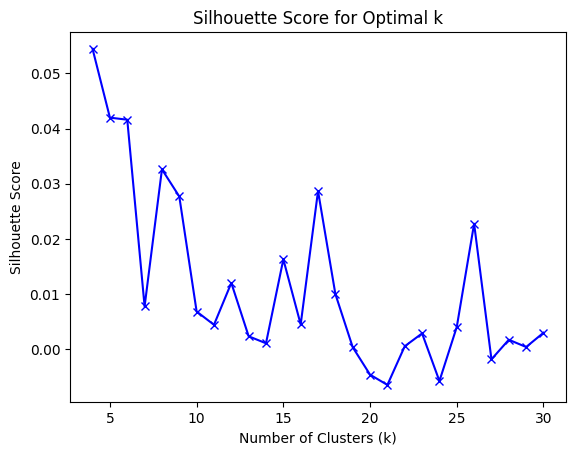

Best k: 4
Best silhouette score: 0.054433026239705744


In [27]:
# Call the find_optimal_k function
best_k, best_score = find_optimal_k(features)

# Print the results
print("Best k:", best_k)
print("Best silhouette score:", best_score)

In [28]:
# Apply KMeans with the optimized number of clusters
kmeans = KMeans(init='k-means++', n_clusters=best_k, random_state=42, n_init=25)
kmeans.fit(features)

# Generate cluster labels for all users
cluster_labels = kmeans.labels_

# Combine cluster labels and user ids into a DataFrame
cluster_df = pd.DataFrame({'userId': user_ids['userId'], 'cluster': cluster_labels})

In [29]:
cluster_df.head()

,userId,cluster
0,1,2
1,9,3
2,24,3
3,29,3
4,31,3


In [30]:
def get_user_recommendations_clusters(user_id, cluster_df, movie_df, ratings_df, popularity_threshold=10, top_n=10):
    """
    Recommend movies to a user based on their cluster. Only recommend movies that the user has not seen.
    
    Args:
        user_id (int): User ID for recommendation.
        cluster_df (pandas.DataFrame): DataFrame with user IDs and their clusters.
        movie_df (pandas.DataFrame): DataFrame with movie information.
        ratings_df (pandas.DataFrame): DataFrame with user ratings.
        popularity_threshold (int): Minimum number of ratings to consider a movie as popular. Default is 10.
        top_n (int): Number of top recommendations to return. Default is 10.
    
    Returns:
        pandas.DataFrame: DataFrame with recommended movies.
    """
    # If the user ID is not found, select a random user ID
    if user_id not in cluster_df['userId'].values:
        print(f"User ID {user_id} not found, selecting a random user.")
        user_id = ratings_df['userId'].sample(1).values[0]
        print(f"Selected user ID {user_id}")

    # Get the cluster of the user
    user_cluster = cluster_df[cluster_df['userId'] == user_id]['cluster'].values[0]
    print(f"User: {user_id} | Cluster: {user_cluster}")

    # Get the top rated movies of users in the same cluster
    cluster_movies = ratings_df[ratings_df['userId'].isin(cluster_df[cluster_df['cluster'] == user_cluster]['userId'])]
    movie_ratings = cluster_movies.groupby('movieId')['rating']
    movie_ratings_count = movie_ratings.count()
    movie_ratings_mean = movie_ratings.mean()
    top_movies = pd.DataFrame({'rating': movie_ratings_mean, 'count': movie_ratings_count}).reset_index()

    # Join with movie_df to get additional details
    top_movies = top_movies.merge(movie_df, on='movieId', how='inner')

    # Filter popular movies based on ratings count threshold
    top_movies = top_movies[top_movies['count'] > popularity_threshold]

    # Sort movies by rating in descending order
    top_movies = top_movies.sort_values(by=['rating', 'count'], ascending=False)

    # Create a new DataFrame for displaying results
    display_df = pd.DataFrame(columns=['movieId', 'title', 'average_rating', 'rating_count'])

    # Fetch the movies already seen by the user
    seen_movies = set(ratings_df[ratings_df['userId'] == user_id]['movieId'].values)

    # Fill in the data
    num_recommendations = 0
    for idx, row in top_movies.iterrows():
        if row['movieId'] not in seen_movies:
            display_df.loc[idx] = [row['movieId'], row['title'], row['rating'], row['count']]
            num_recommendations += 1
            if num_recommendations >= top_n:
                break

    # Return the final DataFrame
    return display_df

In [31]:
user_id = 7
recommend_movies_clusters_kmeans = get_user_recommendations_clusters(user_id, cluster_df, movies_df_clean, ratings_df_clean, top_n=10)
recommend_movies_clusters_kmeans

User: 7 | Cluster: 3


,movieId,title,average_rating,rating_count
90,318,"Shawshank Redemption, The",4.510417,144
272,1217,Ran,4.475000,20
820,44555,"Lives of Others, The (Das leben der Anderen)",4.473684,19
420,1945,On the Waterfront,4.437500,24
250,1172,Cinema Paradiso (Nuovo cinema Paradiso),4.434783,23
203,908,North by Northwest,4.418367,49
205,912,Casablanca,4.388889,72
210,923,Citizen Kane,4.388889,45
268,1212,"Third Man, The",4.369565,23
202,904,Rear Window,4.367347,49


## Apply PCA (Principal Component Analysis) on user profile feature vectors to reduce dimensions

In [32]:
print(f"There are {len(feature_names)} features for each user profile.")

There are 18 features for each user profile.


In [33]:
def plot_correlation_heatmap(df):
    print("Calculating covariance and plotting heatmap...")
    corr = df.cov()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.show()

def find_optimized_components(df, threshold=0.85):
    print(f"Finding optimized number of components to explain at least {threshold*100}% of the variance...")
    for component in range(1, 20):
        pca = PCA(n_components=component)
        transformed_features = pca.fit_transform(df)
        if np.sum(pca.explained_variance_ratio_) >= threshold:
            print(f"Optimized number of components found: {component}")
            return component
    print("Failed to find an optimized number of components within the specified range. Consider increasing the range or lowering the threshold.")
    return None

def transform_features_pca(df, n_components):
    print(f"Applying PCA with {n_components} components...")
    pca = PCA(n_components=n_components)
    transformed_features = pca.fit_transform(df)
    column_names = ['pca{}'.format(i+1) for i in range(n_components)]
    return pd.DataFrame(data=transformed_features, columns=column_names)

def apply_kmeans(df, best_k):
    print(f"Applying K-means clustering with {best_k} clusters...")
    kmeans = KMeans(init='k-means++', n_clusters=best_k, random_state=42, n_init=25)
    kmeans.fit(df)
    print("K-means clustering completed.")
    return kmeans

def apply_kmeans_and_assign_labels(df, num_clusters):
    kmeans = KMeans(init='k-means++', n_clusters=num_clusters, random_state=42, n_init=25)
    df['cluster'] = kmeans.fit_predict(df)
    print("Cluster assignment completed.")
    return df

Calculating covariance and plotting heatmap...


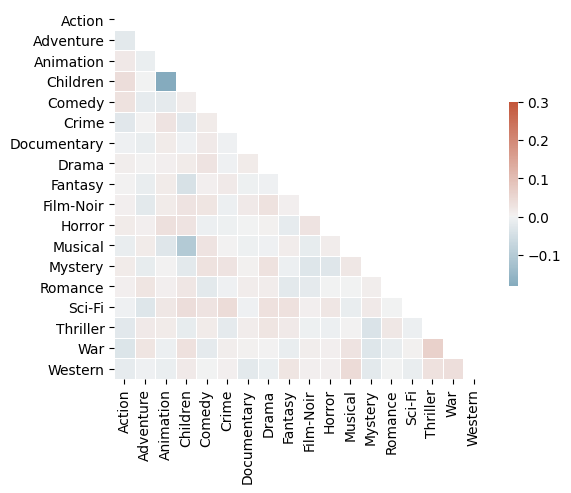

Finding optimized number of components to explain at least 85.0% of the variance...
Optimized number of components found: 12
Applying PCA with 12 components...
Applying K-means clustering with 4 clusters...
K-means clustering completed.
Cluster assignment completed.


In [34]:
plot_correlation_heatmap(user_profiles_df)
n_components = find_optimized_components(user_profiles_df)
transformed_features = transform_features_pca(user_profiles_df, n_components)
cluster_df_pca = user_ids.join(transformed_features)
apply_kmeans(transformed_features, best_k)
cluster_df_pca = apply_kmeans_and_assign_labels(cluster_df_pca, best_k)

In [35]:
user_id = 7
recommend_movies_clusters_pca = get_user_recommendations_clusters(user_id, cluster_df_pca, movies_df_clean, ratings_df_clean, top_n=10)
recommend_movies_clusters_pca

User: 7 | Cluster: 1


,movieId,title,average_rating,rating_count
825,46578,Little Miss Sunshine,4.636364,11
564,2804,"Christmas Story, A",4.600000,15
313,1287,Ben-Hur,4.590909,11
586,3000,Princess Mononoke (Mononoke-hime),4.545455,11
206,913,"Maltese Falcon, The",4.538462,13
493,2324,Life Is Beautiful (La Vita è bella),4.533333,15
202,904,Rear Window,4.527778,18
292,1252,Chinatown,4.500000,20
737,5618,Spirited Away (Sen to Chihiro no kamikakushi),4.464286,14
90,318,"Shawshank Redemption, The",4.441176,68


## Collaborative Filtering based Recommender System using K Nearest Neighbor

In [36]:
# Convert the user-item interaction data into a user-item matrix
user_item_matrix = ratings_df_clean.pivot(index='userId', columns='movieId', values='rating').fillna(0)

# Create a NearestNeighbors model with cosine similarity
model_knn = NearestNeighbors(metric='cosine', algorithm='brute')
model_knn.fit(user_item_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

In [37]:
user_item_matrix

movieId,1,2,3,5,6,7,10,11,16,17,...,78499,79132,81834,81845,89745,91529,99114,109374,109487,112852
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,3.0,0.0,3.0,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
664,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
665,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
666,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
# Function to get personalized recommendations for a given user ID
def get_user_recommendations_knn(user_id, user_item_matrix, movies_df, k=5, top_n=10):
    user_pos = user_item_matrix.index.get_loc(user_id)
    user_row = user_item_matrix.values[user_pos]
    unrated_items = user_row == 0

    # Get the row positions of the k nearest neighbors
    distances, indices = model_knn.kneighbors([user_row], n_neighbors=k+1)  # +1 to exclude self
    neighbor_positions = indices[0][1:]

    # Get the ratings of the nearest neighbors for the unrated items
    neighbor_ratings = user_item_matrix.values[neighbor_positions][:, unrated_items]

    # Calculate the average rating for each unrated item
    item_ratings = np.mean(neighbor_ratings, axis=0)

    # Sort the items by predicted rating (descending order), and get the top recommendations for the user
    top_recommendations = np.argsort(item_ratings)[::-1][:top_n]

    # Get the titles and year for the recommended items from movies_df
    rec_item_ids = user_item_matrix.columns[unrated_items][top_recommendations]
    rec_item_details = movies_df[movies_df['movieId'].isin(rec_item_ids)]

    # Get the predicted ratings for the top recommendations
    predicted_ratings = item_ratings[top_recommendations]

    # Create a DataFrame for displaying the recommendations
    rec_df = pd.DataFrame({
        'movieId': rec_item_ids,
        'title': rec_item_details['title'].values,
        'predicted_rating': predicted_ratings
    })

    return rec_df

# Input user ID and get recommendations
user_id = 7
recommendations_knn = get_user_recommendations_knn(user_id, user_item_matrix, movies_df_clean, k=5, top_n=10)
print("Recommendations:")
recommendations_knn

Recommendations:


,movieId,title,predicted_rating
0,51662,Braveheart,4.7
1,4226,"Shawshank Redemption, The",4.6
2,318,Jaws,4.4
3,3578,Lethal Weapon,4.3
4,3147,Edward Scissorhands,4.2
5,2985,RoboCop,4.1
6,2000,"Green Mile, The",4.1
7,110,Gladiator,4.1
8,1387,Memento,3.9
9,2291,300,3.9


## Collaborative Filtering based Recommender System using Non-negative Matrix Factorization

In [39]:
def nmf_decomposition(user_item_matrix, n_components=16):
    """Perform Non-negative Matrix Factorization."""
    nmf = NMF(n_components=n_components)
    user_features = nmf.fit_transform(user_item_matrix.values)
    item_features = nmf.components_.T
    return user_features, item_features

def get_user_ratings(user_id, user_item_matrix, user_features, item_features):
    """Calculate predicted ratings for all items for a specific user."""
    user_index = user_item_matrix.index.get_loc(user_id)
    user_embedding = user_features[user_index]
    ratings = np.dot(user_embedding, item_features.T)
    return ratings

def get_user_recommendations_nmf(user_id, user_item_matrix, user_features, item_features, movies_df, top_n=10):
    """Get top-n recommended items for a user."""
    if user_id not in user_item_matrix.index:
        raise ValueError(f"Unknown user ID: {user_id}")
    if top_n <= 0:
        raise ValueError(f"top_n must be positive, got {top_n}")

    # Get the predicted ratings for all items
    predicted_ratings = get_user_ratings(user_id, user_item_matrix, user_features, item_features)

    # Get the indices of items that the user has not rated
    unrated_indices = np.where(user_item_matrix.loc[user_id] == 0)

    # Filter out the seen items
    unseen_ratings = predicted_ratings[unrated_indices]

    # Get the indices of the top-n items among the unseen items
    top_unseen_indices = np.argsort(unseen_ratings)[::-1][:top_n]

    # Get the corresponding item IDs
    top_item_ids = user_item_matrix.columns[unrated_indices][top_unseen_indices]

    # Get the details of the recommended items
    rec_item_details = movies_df[movies_df['movieId'].isin(top_item_ids)]

    # Create a DataFrame for displaying the recommendations
    rec_df = pd.DataFrame({
        'movieId': top_item_ids,
        'title': rec_item_details['title'].values,
        'predicted_rating': unseen_ratings[top_unseen_indices]
    })

    return rec_df

# Perform NMF decomposition
user_features, item_features = nmf_decomposition(user_item_matrix, n_components=16)

C:\Users\flori\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\decomposition\_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [40]:
# Get recommendations for a user
user_id = 7
recommendations_nmf = get_user_recommendations_nmf(user_id, user_item_matrix, user_features, item_features, movies_df_clean, top_n=10)
recommendations_nmf

,movieId,title,predicted_rating
0,318,"Usual Suspects, The",3.226462
1,1270,Braveheart,3.226068
2,110,"Shawshank Redemption, The",3.005429
3,480,"Fugitive, The",2.976447
4,50,Jurassic Park,2.656058
5,2858,"Princess Bride, The",2.591949
6,3578,Back to the Future,2.460534
7,1197,American Beauty,2.385194
8,4226,Gladiator,2.352166
9,457,Memento,2.252487


## Rating Prediction using Neural Networks

In [41]:
import tensorflow as tf
import keras
from tensorflow.keras import layers, Model
from sklearn.model_selection import train_test_split

num_users = len(ratings_df_clean['userId'].unique())
num_items = len(ratings_df_clean['movieId'].unique())
print(f"There are total `{num_users}` of users and `{num_items}` items")

class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_items, embedding_size=16, **kwargs):
        """
           Constructor
           :param int num_users: number of users
           :param int num_items: number of items
           :param int embedding_size: the size of embedding vector
        """
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_size = embedding_size
        
        # Define a user_embedding vector
        # Input dimension is the num_users
        # Output dimension is the embedding size
        self.user_embedding_layer = layers.Embedding(
            input_dim=num_users,
            output_dim=embedding_size,
            name='user_embedding_layer',
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        # Define a user bias layer
        self.user_bias = layers.Embedding(
            input_dim=num_users,
            output_dim=1,
            name="user_bias")
        
        # Define an item_embedding vector
        # Input dimension is the num_items
        # Output dimension is the embedding size
        self.item_embedding_layer = layers.Embedding(
            input_dim=num_items,
            output_dim=embedding_size,
            name='item_embedding_layer',
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        # Define an item bias layer
        self.item_bias = layers.Embedding(
            input_dim=num_items,
            output_dim=1,
            name="item_bias")
        
    def call(self, inputs):
        """
           method to be called during model fitting
           
           :param inputs: user and item one-hot vectors
        """
        # Compute the user embedding vector
        user_vector = self.user_embedding_layer(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        item_vector = self.item_embedding_layer(inputs[:, 1])
        item_bias = self.item_bias(inputs[:, 1])
        dot_user_item = tf.tensordot(user_vector, item_vector, 2)
        # Add all the components (including bias)
        x = dot_user_item + user_bias + item_bias
        # Sigmoid output layer to output the probability
        return tf.nn.relu(x)
    
    
# process_dataset function
def process_dataset(raw_data):
    
    encoded_data = raw_data.copy()
    
    # Mapping user ids to indices
    user_list = encoded_data["userId"].unique().tolist()
    user_id2idx_dict = {x: i for i, x in enumerate(user_list)}
    user_idx2id_dict = {i: x for i, x in enumerate(user_list)}
    
    # Mapping movie ids to indices
    movie_list = encoded_data["movieId"].unique().tolist()
    movie_id2idx_dict = {x: i for i, x in enumerate(movie_list)}
    movie_idx2id_dict = {i: x for i, x in enumerate(movie_list)}

    # Convert original user ids to idx
    encoded_data["userId"] = encoded_data["userId"].map(user_id2idx_dict)
    # Convert original movie ids to idx
    encoded_data["movieId"] = encoded_data["movieId"].map(movie_id2idx_dict)
    # Convert rating to int
    encoded_data["rating"] = encoded_data["rating"].values.astype("int")

    return encoded_data, user_idx2id_dict, movie_idx2id_dict
    
# generate_train_test_datasets function
def generate_train_test_datasets(dataset, scale=True):

    min_rating = min(dataset["rating"])
    max_rating = max(dataset["rating"])

    dataset = dataset.sample(frac=1, random_state=42)
    x = dataset[["userId", "movieId"]].values
    if scale:
        y = dataset["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
    else:
        y = dataset["rating"].values

    # Assuming training on 80% of the data and validating on 10%, and testing 10%
    train_indices = int(0.8 * dataset.shape[0])
    test_indices = int(0.9 * dataset.shape[0])

    x_train, x_val, x_test, y_train, y_val, y_test = (
        x[:train_indices],
        x[train_indices:test_indices],
        x[test_indices:],
        y[:train_indices],
        y[train_indices:test_indices],
        y[test_indices:],
    )
    return x_train, x_val, x_test, y_train, y_val, y_test

There are total `476` of users and `888` items


In [42]:
# Prepare data
encoded_data, user_idx2id_dict, movie_idx2id_dict = process_dataset(ratings_df_clean)
x_train, x_val, x_test, y_train, y_val, y_test = generate_train_test_datasets(encoded_data)

In [43]:
user_indices = x_train[:, 0]
user_indices

array([110, 177,  57, ..., 468, 405,  20], dtype=int64)

In [44]:
item_indices = x_train[:, 1]
item_indices

array([401,  26, 548, ..., 280, 808, 659], dtype=int64)

In [45]:
encoded_data

,userId,movieId,rating,timestamp
0,0,0,4,1217897793
1,0,1,1,1217895807
2,0,2,4,1217896246
3,0,3,4,1217896556
4,0,4,4,1217896523
...,...,...,...,...
56281,475,733,4,1344747165
56282,475,411,3,1367129093
56283,475,412,4,1415763807
56284,475,511,4,1415421771


In [46]:
# Instantiate and compile model
embedding_size = 16
model = RecommenderNet(num_users, num_items, embedding_size)

model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.Adam(),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

# Fit the model
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=10,
    verbose=1,
    validation_data=(x_val, y_val),
)

Epoch 1/10
704/704 [==============================] - 3s 2ms/step - loss: 0.2326 - root_mean_squared_error: 0.4822 - val_loss: 0.0549 - val_root_mean_squared_error: 0.2342
Epoch 2/10
704/704 [==============================] - 1s 2ms/step - loss: 0.0489 - root_mean_squared_error: 0.2210 - val_loss: 0.0669 - val_root_mean_squared_error: 0.2585
Epoch 3/10
704/704 [==============================] - 1s 2ms/step - loss: 0.0419 - root_mean_squared_error: 0.2045 - val_loss: 0.0552 - val_root_mean_squared_error: 0.2348
Epoch 4/10
704/704 [==============================] - 1s 2ms/step - loss: 0.0386 - root_mean_squared_error: 0.1962 - val_loss: 0.0461 - val_root_mean_squared_error: 0.2145
Epoch 5/10
704/704 [==============================] - 1s 2ms/step - loss: 0.0374 - root_mean_squared_error: 0.1933 - val_loss: 0.0492 - val_root_mean_squared_error: 0.2216
Epoch 6/10
704/704 [==============================] - 1s 2ms/step - loss: 0.0372 - root_mean_squared_error: 0.1928 - val_loss: 0.0420 - val_

In [47]:
# Save the model
model.save("recommender_model")

INFO:tensorflow:Assets written to: recommender_model\assets


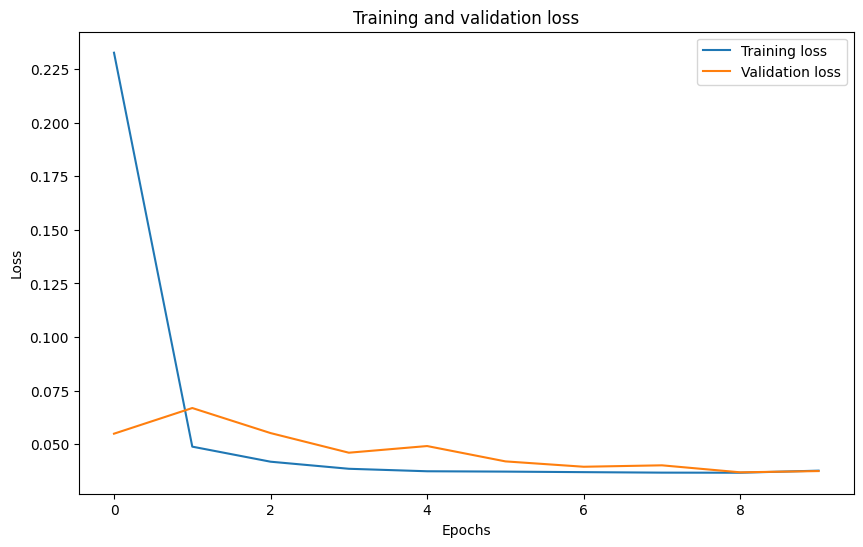

176/176 [==============================] - 0s 1ms/step - loss: 0.0885 - root_mean_squared_error: 0.2974
Test Loss:  0.08850236982107162
Test RMSE:  0.2973811626434326


In [48]:
# Plot training and validation loss
plt.figure(figsize=(10,6))
plt.plot(history.history["loss"], label="Training loss")
plt.plot(history.history["val_loss"], label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Evaluate the model
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print("Test Loss: ", test_loss)
print("Test RMSE: ", test_accuracy)

In [49]:
# Get the embeddings
user_embeddings = model.get_layer('user_embedding_layer').get_weights()[0]
item_embeddings = model.get_layer('item_embedding_layer').get_weights()[0]

print("User Embeddings:", user_embeddings)
print("Item Embeddings:", item_embeddings)

User Embeddings: [[ 0.02095192  0.07860813 -0.01398531 ...  0.03139098 -0.08835985
  -0.01203039]
 [-0.09281244  0.06973865 -0.10167153 ... -0.02600434 -0.02127068
   0.06256864]
 [ 0.03567737  0.08598878  0.01823376 ... -0.02838574 -0.03367279
  -0.0569022 ]
 ...
 [ 0.05338017  0.01844286 -0.09589852 ...  0.07017177 -0.02064222
   0.02422507]
 [ 0.00788442 -0.10887665  0.01867465 ...  0.01022242 -0.05095831
  -0.01037856]
 [-0.04673059  0.05031267  0.02594168 ... -0.04003593 -0.01994928
  -0.00905392]]
Item Embeddings: [[ 0.0893026  -0.04704754  0.05596786 ...  0.00490282  0.01084494
  -0.03590019]
 [ 0.03012539  0.02462205 -0.06451767 ...  0.00132053  0.00592731
   0.04561984]
 [-0.05809374 -0.01985121 -0.0542242  ... -0.00290812 -0.00998678
  -0.06807474]
 ...
 [ 0.0028949   0.03891452 -0.02769346 ... -0.04835302 -0.00425294
  -0.06181271]
 [ 0.08669914 -0.01686624 -0.03369086 ...  0.04280474 -0.02451331
   0.01945787]
 [-0.00648014 -0.03735536  0.0445422  ...  0.07062015 -0.0217487

In [50]:
model.summary()

Model: "recommender_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 user_embedding_layer (Embed  multiple                 7616      
 ding)                                                           
                                                                 
 user_bias (Embedding)       multiple                  476       
                                                                 
 item_embedding_layer (Embed  multiple                 14208     
 ding)                                                           
                                                                 
 item_bias (Embedding)       multiple                  888       
                                                                 
Total params: 23,188
Trainable params: 23,188
Non-trainable params: 0
_________________________________________________________________


In [51]:
# User features
user_latent_features = model.get_layer('user_embedding_layer').get_weights()[0]
print(f"User features shape: {user_latent_features.shape}")

User features shape: (476, 16)


In [52]:
user_latent_features[0]

array([ 0.02095192,  0.07860813, -0.01398531,  0.03131442,  0.06081598,
        0.04455452, -0.00559619, -0.09123084,  0.015902  ,  0.05606325,
       -0.01765312,  0.01337856,  0.02123669,  0.03139098, -0.08835985,
       -0.01203039], dtype=float32)

In [53]:
item_latent_features = model.get_layer('item_embedding_layer').get_weights()[0]
print(f"Item features shape: {item_latent_features.shape}")

Item features shape: (888, 16)


In [54]:
item_latent_features[0]

array([ 0.0893026 , -0.04704754,  0.05596786,  0.07279848, -0.03538453,
        0.04644234,  0.0612354 , -0.06372938, -0.04293982, -0.03042344,
        0.03053185,  0.02012541, -0.01467795,  0.00490282,  0.01084494,
       -0.03590019], dtype=float32)

#### Custom Model

In [55]:
class CustomRecommenderNet(Model):
    def __init__(self, num_users, num_items, embedding_size=50, **kwargs):
        super(CustomRecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_size = embedding_size
        self.user_embedding_layer = layers.Embedding(
            input_dim=num_users,
            output_dim=embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.item_embedding_layer = layers.Embedding(
            input_dim=num_items,
            output_dim=embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.item_bias = layers.Embedding(num_items, 1)
        # Added dropout layers
        self.dropout = layers.Dropout(0.2)

    def call(self, inputs):
        user_vector = self.user_embedding_layer(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        item_vector = self.item_embedding_layer(inputs[:, 1])
        item_bias = self.item_bias(inputs[:, 1])
        
        # dot_user_item = tf.tensordot(user_vector, item_vector, 2)
        dot_user_item = tf.reduce_sum(user_vector * item_vector, axis=1, keepdims=True)
        # Add dropout on dot_product
        x = self.dropout(dot_user_item)

        x = x + user_bias + item_bias
        return tf.nn.sigmoid(x)

# Then you can compile, fit, and evaluate this new model just like before:
embedding_size = 50
model_custom = CustomRecommenderNet(num_users, num_items, embedding_size)

model_custom.compile(
    loss=tf.keras.losses.MeanSquaredError(), 
    optimizer=keras.optimizers.Adam(learning_rate=0.01), 
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

history_custom = model_custom.fit(
    x=x_train, 
    y=y_train, 
    batch_size=64, 
    epochs=20, 
    verbose=1, 
    validation_data=(x_val, y_val)
)

model_custom.evaluate(x_test, y_test)

Epoch 1/20
704/704 [==============================] - 3s 2ms/step - loss: 0.0422 - root_mean_squared_error: 0.2010 - val_loss: 0.0347 - val_root_mean_squared_error: 0.1783
Epoch 2/20
704/704 [==============================] - 1s 2ms/step - loss: 0.0296 - root_mean_squared_error: 0.1613 - val_loss: 0.0385 - val_root_mean_squared_error: 0.1848
Epoch 3/20
704/704 [==============================] - 1s 2ms/step - loss: 0.0256 - root_mean_squared_error: 0.1457 - val_loss: 0.0395 - val_root_mean_squared_error: 0.1864
Epoch 4/20
704/704 [==============================] - 1s 2ms/step - loss: 0.0238 - root_mean_squared_error: 0.1383 - val_loss: 0.0409 - val_root_mean_squared_error: 0.1895
Epoch 5/20
704/704 [==============================] - 1s 2ms/step - loss: 0.0232 - root_mean_squared_error: 0.1356 - val_loss: 0.0411 - val_root_mean_squared_error: 0.1896
Epoch 6/20
704/704 [==============================] - 1s 2ms/step - loss: 0.0232 - root_mean_squared_error: 0.1349 - val_loss: 0.0415 - val_

[0.040839783847332, 0.1884787231683731]

In [56]:
def get_user_recommendations_neuralnet(user_id, ratings, movies, top_n):
    # Retrieve user embedding
    item_embeddings = model_custom.item_embedding_layer.weights[0].numpy()
    user_embeddings = model_custom.user_embedding_layer.weights[0].numpy()[user_id]
    
    # Compute dot product of user embedding and all movie embeddings
    scores = np.dot(user_embeddings, item_embeddings.T)
    
    # Get the seen movie indices
    seen_movie_indices = ratings[ratings['userId'] == user_id]['movieId'].values

    # Filter out seen movies
    unseen_movie_indices = [idx for idx in range(item_embeddings.shape[0]) if idx not in seen_movie_indices]
    unseen_movie_scores = scores[unseen_movie_indices]

    # Get indices of top N scores
    top_n_indices = np.argsort(unseen_movie_scores)[-top_n:][::-1]
    
    # Map indices back to movie IDs
    top_n_movie_ids = [movie_idx2id_dict[unseen_movie_indices[i]] for i in top_n_indices]

    # Fetch the titles for the recommended movies
    top_n_movie_titles = movies[movies['movieId'].isin(top_n_movie_ids)]['title'].values

    # Fetch the predicted ratings
    user_bias = model_custom.user_bias.weights[0].numpy()[user_id]
    item_biases = [model_custom.item_bias.weights[0].numpy()[unseen_movie_indices[i]] for i in top_n_indices]
    item_biases = np.array(item_biases).reshape(-1)
    predicted_ratings = tf.nn.sigmoid(unseen_movie_scores[top_n_indices] + user_bias + item_biases)

    # Scale ratings back to original scale (assuming original scale was 1 to 5)
    scaled_ratings = predicted_ratings.numpy() * 4 + 1

    recommendations = pd.DataFrame({
        'movieId': top_n_movie_ids,
        'title': top_n_movie_titles,
        'predicted_rating': scaled_ratings
    }).sort_values(by='predicted_rating', ascending=False)

    return recommendations

recommendations = get_user_recommendations_neuralnet(user_id, ratings_df_clean, movies_df_clean, top_n=10)
recommendations

,movieId,title,predicted_rating
5,48516,Rocky,4.672022
7,1198,"Last Samurai, The",4.588970
4,1921,Pi,4.511679
2,1954,Raiders of the Lost Ark (Indiana Jones and the...,4.411548
6,59315,10 Things I Hate About You,4.354412
1,2572,Space Jam,4.327998
9,7143,Iron Man,4.300622
0,485,Last Action Hero,4.056371
8,1717,"Departed, The",3.660812
3,673,Scream 2,3.616252


## Regression-based Rating Score Prediction using Embedding Features

In [57]:
def extract_embeddings(model):
    user_embeddings = model.user_embedding_layer.weights[0].numpy()
    item_embeddings = model.item_embedding_layer.weights[0].numpy()

    print(f'Shape of user embeddings: {user_embeddings.shape}')
    print(f'Shape of item embeddings: {item_embeddings.shape}')
    
    return user_embeddings, item_embeddings

# Define user and item feature names
USER_FEATURES = [f"UFeature{i}" for i in range(embedding_size)]
ITEM_FEATURES = [f"CFeature{i}" for i in range(embedding_size)]

def embeddings_to_dataframe(user_embeddings, item_embeddings):
    user_emb_df = pd.DataFrame(user_embeddings, columns=USER_FEATURES)
    item_emb_df = pd.DataFrame(item_embeddings, columns=ITEM_FEATURES)
    
    print(f'User embedding dataframe shape: {user_emb_df.shape}')
    print(f'Item embedding dataframe shape: {item_emb_df.shape}')
    
    return user_emb_df, item_emb_df

def add_unique_ids(user_emb_df, item_emb_df, ratings_df_clean):
    user_emb_df['userId'] = ratings_df_clean['userId'].unique()
    item_emb_df['movieId'] = ratings_df_clean['movieId'].unique()

    print(f"Number of unique users: {len(user_emb_df['userId'])}")
    print(f"Number of unique movies: {len(item_emb_df['movieId'])}")
    
    return user_emb_df, item_emb_df

def merge_ratings_with_embeddings(ratings_df_clean, user_emb_df, item_emb_df):
    merged_df_net = ratings_df_clean.merge(user_emb_df, on='userId').merge(item_emb_df, on='movieId').fillna(0)

    print(f'Merged dataframe shape: {merged_df_net.shape}')
    
    return merged_df_net

def aggregate_features(merged_df_net):
    regression_dataset = merged_df_net[USER_FEATURES] + merged_df_net[ITEM_FEATURES].values
    regression_dataset.columns = [f"Feature{i}" for i in range(embedding_size)]
    regression_dataset['rating'] = merged_df_net['rating']

    print(f'Aggregated dataset shape: {regression_dataset.shape}')
    
    return regression_dataset

def split_dataset(regression_dataset):
    X = regression_dataset.drop(columns=['rating'])
    y = regression_dataset['rating']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

    print(f'Training set size: {len(X_train)}')
    print(f'Test set size: {len(X_test)}')

    return X_train, X_test, y_train, y_test


from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

def train_and_evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    # Training the model
    model.fit(X_train, y_train)

    # Making predictions
    y_pred = model.predict(X_test)

    # Calculate and print metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    print(f"{model_name} RMSE: {rmse}")
    print(f"{model_name} R2 Score: {r2}")
    print(f"{model_name} MAE: {mae}\n")

    # Return the metrics for comparison
    return rmse, r2, mae

In [58]:
# Main Execution
user_embeddings, item_embeddings = extract_embeddings(model_custom)
user_emb_df, item_emb_df = embeddings_to_dataframe(user_embeddings, item_embeddings)
user_emb_df, item_emb_df = add_unique_ids(user_emb_df, item_emb_df, ratings_df_clean)
merged_df_net = merge_ratings_with_embeddings(ratings_df_clean, user_emb_df, item_emb_df)
regression_dataset = aggregate_features(merged_df_net)
X_train, X_test, y_train, y_test = split_dataset(regression_dataset)

Shape of user embeddings: (476, 50)
Shape of item embeddings: (888, 50)
User embedding dataframe shape: (476, 50)
Item embedding dataframe shape: (888, 50)
Number of unique users: 476
Number of unique movies: 888
Merged dataframe shape: (56286, 104)
Aggregated dataset shape: (56286, 51)
Training set size: 39400
Test set size: 16886


In [59]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR

# Defining the models
models = [
    ('Random Forest', RandomForestRegressor(n_estimators=10, random_state=42)),
    ('Linear Regression', LinearRegression()),
    ('Gradient Boosting', GradientBoostingRegressor(random_state=42)),
]

# Compare models
model_results = {}
for model_name, model in models:
    performance = train_and_evaluate_model(model, X_train, y_train, X_test, y_test, model_name)
    model_results[model_name] = {'model': model, 'performance': performance}

# Determine the best model
best_model_name, best_model_info = max(model_results.items(), key=lambda x: x[1]['performance'][1])  # compare based on R2
best_model_rgr = best_model_info['model']
print(f"Best Model: {best_model_name} with R2 Score: {best_model_info['performance'][1]}")

Random Forest RMSE: 0.9387857561558715
Random Forest R2 Score: 0.12036817101344754
Random Forest MAE: 0.7360031979154329

Linear Regression RMSE: 0.9674293443199607
Linear Regression R2 Score: 0.06587183815591058
Linear Regression MAE: 0.7607734635106961

Gradient Boosting RMSE: 0.9186431057599502
Gradient Boosting R2 Score: 0.15771010072237868
Gradient Boosting MAE: 0.7198976991744578

Best Model: Gradient Boosting with R2 Score: 0.15771010072237868


In [60]:
def get_user_seen_unseen_items(user_id, user_emb_df, item_emb_df, ratings_df_clean):
    """
    Fetch seen and unseen items for the target user.

    :param user_id: Target user id
    :param user_emb_df: User embeddings dataframe
    :param item_emb_df: Item embeddings dataframe
    :param ratings_df_clean: Ratings dataframe

    :returns: Embeddings for seen and unseen items
    """
    # Fetch the user's embedding vector
    target_user_emb = user_emb_df[user_emb_df['userId'] == user_id]

    if target_user_emb.empty:
        print(f"No embeddings found for user {user_id}. Choosing a random user.")
        user_id = ratings_df_clean['userId'].sample(1).iloc[0]
        print(f"Chosen user_id: {user_id}")
        target_user_emb = user_emb_df[user_emb_df['userId'] == user_id]

    # Get the list of items that the user has interacted with
    seen_items = ratings_df_clean[ratings_df_clean['userId'] == user_id]['movieId'].unique()

    # Get the embeddings of unseen items
    unseen_item_emb = item_emb_df[~item_emb_df['movieId'].isin(seen_items)]
    
    if unseen_item_emb.empty:
        raise ValueError(f"All items have been seen by user {user_id}")
    
    return target_user_emb, unseen_item_emb


def get_predicted_ratings(user_emb, unseen_item_emb, model):
    """
    Predict the ratings for unseen items.

    :param user_emb: User embeddings dataframe for target user
    :param unseen_item_emb: Unseen item embeddings dataframe
    :param model: Trained model to predict ratings
    :param training_columns: The column names of the training data

    :returns: Dataframe with unseen items and their predicted ratings
    """
    # Repeat the user's embedding vector to match the number of unseen items
    repeated_user_emb = pd.concat([user_emb]*len(unseen_item_emb), ignore_index=True)

    # Select only the relevant columns
    repeated_user_emb = repeated_user_emb[USER_FEATURES]
    unseen_item_emb = unseen_item_emb[ITEM_FEATURES+['movieId']]

    # Combine user and item embedding vectors
    input_data = repeated_user_emb.values + unseen_item_emb.drop(columns='movieId').values

    # Predict the ratings
    predicted_ratings = model.predict(input_data)

    if model != best_model_rgr:
        # Decode the predicted ratings
        predicted_ratings = label_encoder.inverse_transform(predicted_ratings)

    # Create a DataFrame with the results
    results = pd.DataFrame({
        'movieId': unseen_item_emb['movieId'],
        'predicted_rating': predicted_ratings.ravel()
    })

    return results


def get_user_recommendations_embeddings(user_id, user_emb_df, item_emb_df, ratings_df_clean, model, movies_df_clean, top_n=10):
    """
    Recommend items to a user.

    :param user_id: Target user id
    :param user_emb_df: User embeddings dataframe
    :param item_emb_df: Item embeddings dataframe
    :param ratings_df_clean: Ratings dataframe
    :param model: Trained model to predict ratings
    :param movies_df_clean: Movies dataframe
    :param top_n: Number of recommendations to return

    :returns: Dataframe with recommended items and their predicted ratings
    """
    user_emb, unseen_item_emb = get_user_seen_unseen_items(user_id, user_emb_df, item_emb_df, ratings_df_clean)
    results = get_predicted_ratings(user_emb, unseen_item_emb, model)

    # Sort by predicted rating
    results = results.sort_values(by='predicted_rating', ascending=False)

    # Limit the number of recommendations
    results = results.head(top_n)

    # Add movie titles
    results = results.merge(movies_df_clean[['movieId', 'title']], on='movieId', how='left')
    results = results[['movieId', 'title', 'predicted_rating']]
                       
    return results

In [61]:
recommendations_regression = get_user_recommendations_embeddings(user_id, user_emb_df, item_emb_df, ratings_df_clean, best_model_rgr, movies_df_clean, top_n=10)
recommendations_regression

C:\Users\flori\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


,movieId,title,predicted_rating
0,2067,Doctor Zhivago,4.435931
1,2985,RoboCop,4.408057
2,3160,Magnolia,4.346765
3,4973,"Amelie (Fabuleux destin d'Amélie Poulain, Le)",4.342389
4,2313,"Elephant Man, The",4.337854
5,353,"Crow, The",4.337419
6,3552,Caddyshack,4.334361
7,1059,William Shakespeare's Romeo + Juliet,4.329677
8,3751,Chicken Run,4.319738
9,62,Mr. Holland's Opus,4.313499


## Classification-based Rating Mode Prediction using Embedding Features

In [62]:
from sklearn.metrics import accuracy_score, f1_score

def train_and_evaluate_classification_model(model, X_train, y_train, X_test, y_test, model_name):
    # Training the model
    model.fit(X_train, y_train)

    # Making predictions
    y_pred = model.predict(X_test)

    # Calculate and print metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f"{model_name} Accuracy: {accuracy}")
    print(f"{model_name} F1 Score: {f1}\n")

    # Return the metrics for comparison
    return accuracy, f1

In [63]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

X = regression_dataset.drop(columns=['rating'])
y_raw = regression_dataset['rating']

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_raw.values.ravel())

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# Defining the models
models = [
    ('Random Forest', RandomForestClassifier(n_estimators=50, random_state=42)),
    ('Logistic Regression', LogisticRegression(max_iter=1000)),
    ('Random Forest', RandomForestClassifier(max_depth=5, n_estimators=10, random_state=42)),
]

# Compare models
model_results = {}
for model_name, model in models:
    performance = train_and_evaluate_classification_model(model, X_train, y_train, X_test, y_test, model_name)
    model_results[model_name] = {'model': model, 'performance': performance}

# Determine the best model
best_model_name, best_model_info = max(model_results.items(), key=lambda x: x[1]['performance'][1])  # compare based on F1 score
best_model_cls = best_model_info['model']
print(f"Best Model: {best_model_name} with F1 Score: {best_model_info['performance'][1]}")

Random Forest Accuracy: 0.3372616368589364
Random Forest F1 Score: 0.2770720670976663

Logistic Regression Accuracy: 0.30350586284496034
Logistic Regression F1 Score: 0.21971444658991135

Random Forest Accuracy: 0.30161080184768446
Random Forest F1 Score: 0.1628614334410268

Best Model: Logistic Regression with F1 Score: 0.21971444658991135


In [64]:
recommendations_classification = get_user_recommendations_embeddings(user_id, user_emb_df, item_emb_df, ratings_df_clean, best_model_cls, movies_df_clean, top_n=10)
recommendations_classification

C:\Users\flori\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


,movieId,title,predicted_rating
0,2872,Excalibur,5.0
1,1183,"English Patient, The",5.0
2,51662,300,5.0
3,51255,Hot Fuzz,5.0
4,33166,Crash,5.0
5,69757,(500) Days of Summer,5.0
6,6942,Love Actually,5.0
7,91529,"Dark Knight Rises, The",5.0
8,1639,Chasing Amy,5.0
9,3147,"Green Mile, The",5.0
